In [ ]:
from google.cloud import storage

def download_from_gcs(bucket_name, source_blob_name, destination_file_name, credential_path):
    """
    Download a file from Google Cloud Storage.

    :param bucket_name: GCS bucket name
    :param source_blob_name: GCS blob name (path to file in bucket)
    :param destination_file_name: Local path to save the downloaded file
    :param credential_path: Path to the service account credential .json file
    """

    # Set the credentials
    storage_client = storage.Client.from_service_account_json(credential_path)

    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)
    print(f"File {source_blob_name} downloaded to {destination_file_name}.")

credential_path = 'mockmate_key.json'
download_from_gcs(
    bucket_name='mockmate-app-data',
    source_blob_name='dvc_store/src/model/training_data/ready.pkl',
    destination_file_name='ready.pkl',
    credential_path=credential_path
)


# https://storage.cloud.google.com/mockmate-app-data/

File dvc_store/src/model/training_data/ready.pkl downloaded to ready.pkl.


In [ ]:
import re
import torch
import pickle
from transformers import LlamaTokenizer, LlamaForCausalLM, TrainingArguments, BitsAndBytesConfig
from peft import LoraConfig

# ===================
# LOAD MODEL AND TOKENIZER
# ===================

# Define the path to the pre-trained model
model_path = 'openlm-research/open_llama_3b_v2'

# Load the tokenizer and model associated with the given model path
tokenizer = LlamaTokenizer.from_pretrained(model_path)
model = LlamaForCausalLM.from_pretrained(model_path, load_in_8bit=True, device_map='auto')

/home/user/miniforge3/envs/rudra-3_10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
# ===================
# TEXT GENERATION EXAMPLE
# ===================

# Given prompt for generating a solution
prompt = """What is 9 + 10?"""  # shortened for brevity

# Tokenize the prompt and generate a response
input_ids = tokenizer(prompt, return_tensors="pt").input_ids
generation_output = model.generate(input_ids=input_ids)
print(tokenizer.decode(generation_output[0]))

/home/user/miniforge3/envs/rudra-3_10/lib/python3.10/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/user/miniforge3/envs/rudra-3_10/lib/python3.10/site-packages/transformers/generation/utils.py:1539: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
2023-10-29 15:59:39.393022: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN wh

<s>What is 9 + 10?
9 + 10 = 19


In [ ]:
# ===================
# LOAD DATASET
# ===================

import pickle

file = open('ready.pkl', 'rb')
res = pickle.load(file)
file.close()


dataset = res[0]

for i in dataset:
  print(i["prompt"])
  print(i["response"])
  break

Below is an instruction that describes a coding task, along with given constraints and examples of test cases that you are required to pass.
    Write a solution that appropriately solves the coding task using python code and an explanation for your code.
### Instruction: Given an array of integers `nums` and an integer `target`, return _indices of the two numbers such that they add up to `target`_.

You may assume that each input would have **_exactly_ one solution**, and you may not use the _same_ element twice.

You can return the answer in any order.
### Constraints: *   `2 <= nums.length <= 104`
*   `-109 <= nums[i] <= 109`
*   `-109 <= target <= 109`
*   **Only one valid answer exists.**
### Examples: **Example 1:**

**Input:** nums = \[2,7,11,15\], target = 9
**Output:** \[0,1\]
**Explanation:** Because nums\[0\] + nums\[1\] == 9, we return \[0, 1\].
**Example 2:**

**Input:** nums = \[3,2,4\], target = 6
**Output:** \[1,2\]
**Example 3:**

**Input:** nums = \[3,3\], target = 6


In [ ]:
# ===================
# LORA CONFIGURATION
# ===================

# Configuration for LORA (Linear Reweighting)
lora_config = LoraConfig(
    r=16,
    target_modules=['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'down_proj', 'up_proj', 'lm_head'],
    lora_alpha=8,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Extract Linear layer names from the model
model_modules_str = str(model.modules)
linear_layer_names = re.findall(r'\((\w+)\): Linear', model_modules_str)
target_modules = list(set(linear_layer_names))

In [ ]:
import torch
from transformers import Trainer, LlamaTokenizer, LlamaForCausalLM
from torch.utils.data import IterableDataset, random_split
import mlflow

# Constants
MODEL_PATH = 'openlm-research/open_llama_3b_v2'
SAVED_WEIGHTS_PATH = "saved_weights.h5"
SEQ_LENGTH = 1024

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
print(len(train_dataset), len(valid_dataset))

1885 472


In [ ]:
# ===================
# TRAINING CONFIGURATION
# ===================

# Define training arguments
training_args = TrainingArguments(
    output_dir="saved_weights.h5",
    dataloader_drop_last=True,
    gradient_checkpointing=True,
    gradient_accumulation_steps=4,
    optim='adamw_hf',
    evaluation_strategy="steps",
    max_steps=len(train_dataset),
    eval_steps=50,
    save_steps=50,
    logging_steps=50,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=1,
    learning_rate=1e-5,
    lr_scheduler_type="linear",
    warmup_steps=100,
    warmup_ratio=0.03,
    weight_decay=0.05,
    max_grad_norm=0.3,
    fp16=True,
)

# Configuration for 4-bit loading in BitsAndBytes
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType

# Load tokenizer and add special tokens
tokenizer = LlamaTokenizer.from_pretrained(MODEL_PATH)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Load pre-trained model with quantization config
model = LlamaForCausalLM.from_pretrained(MODEL_PATH, device_map='auto', quantization_config=nf4_config)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 25,989,120 || all params: 3,452,462,720 || trainable%: 0.7527704745208661


In [ ]:
class ConstantLengthDataset(IterableDataset):
    """
    Iterable dataset that returns constant length chunks of tokens from stream of text files.
        Args:
            tokenizer (Tokenizer): The processor used for proccessing the data.
            dataset (dataset.Dataset): Dataset with text files.
            infinite (bool): If True the iterator is reset after dataset reaches end else stops.
            seq_length (int): Length of token sequences to return.
            num_of_sequences (int): Number of token sequences to keep in buffer.
            chars_per_token (int): Number of characters per token used to estimate number of tokens in text buffer.
    """

    def __init__(
        self,
        tokenizer,
        dataset,
        infinite=False,
        seq_length=1024,
        num_of_sequences=1024,
        chars_per_token=2.95,
    ):
        self.tokenizer = tokenizer
        self.concat_token_id = tokenizer.eos_token_id if tokenizer.eos_token_id else 49152
        self.dataset = dataset
        self.seq_length = seq_length
        self.infinite = infinite
        self.current_size = 0
        self.max_buffer_size = seq_length * chars_per_token * num_of_sequences
        self.content_field = "prompt"

    def __iter__(self):
        iterator = iter(self.dataset)
        more_examples = True
        while more_examples:
            buffer, buffer_len = [], 0
            while True:
                if buffer_len >= self.max_buffer_size:
                    break
                try:
                    buffer.append(next(iterator)[self.content_field])
                    buffer_len += len(buffer[-1])
                except StopIteration:
                    if self.infinite:
                        iterator = iter(self.dataset)
                    else:
                        more_examples = False
                        break
            tokenized_inputs = self.tokenizer(buffer, truncation=False)["input_ids"]
            all_token_ids = []
            for tokenized_input in tokenized_inputs:
                all_token_ids.extend(tokenized_input + [self.concat_token_id])
            for i in range(0, len(all_token_ids), self.seq_length):
                input_ids = all_token_ids[i : i + self.seq_length]
                if len(input_ids) == self.seq_length:
                    self.current_size += 1
                    yield {
                        "input_ids": torch.LongTensor(input_ids),
                        "labels": torch.LongTensor(input_ids),
                    }

In [ ]:
# Convert dataset to ConstantLength format
train_ds = ConstantLengthDataset(tokenizer, train_dataset, infinite=True)
valid_ds = ConstantLengthDataset(tokenizer, valid_dataset)

In [ ]:
# Initialize the Trainer and start training
train_ds.start_iteration = 0
trainer = Trainer(model=model, args=training_args, train_dataset=train_ds, eval_dataset=valid_ds)
with mlflow.start_run(run_name="test_fine_tune"):
    trainer.train()
print("Finished training")

/home/user/miniforge3/envs/rudra-3_10/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/home/user/miniforge3/envs/rudra-3_10/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/user/miniforge3/envs/rudra-3_10/lib/python3.10/site-packages/torch/utils/checkpoint.p

Step,Training Loss,Validation Loss
50,1.447600,1.433662
100,1.441800,1.432423
150,1.436800,1.423455
200,1.424500,1.409581
250,1.409800,1.393424
300,1.390100,1.377060
350,1.379900,1.361493
400,1.362600,1.347436
450,1.346800,1.334697
500,1.333600,1.323372


/home/user/miniforge3/envs/rudra-3_10/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/user/miniforge3/envs/rudra-3_10/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/user/miniforge3/envs/rudra-3_10/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_ree

Finished training


In [ ]:
# Save the trained model
trainer.save_model(SAVED_WEIGHTS_PATH)

In [ ]:
from transformers import LlamaTokenizer, LlamaForCausalLM

model_path = "saved_weights.h5"
tokenizer2 = LlamaTokenizer.from_pretrained("openlm-research/open_llama_3b_v2")
model2 = LlamaForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_path, load_in_8bit=True, device_map='auto'
)

In [ ]:
def output_response(tokenizer_in_use, model_in_use, user_query):
    """
    Generate the output response for a given user query.

    Parameters:
        tokenizer_in_use (Tokenizer): The tokenizer object to be used for converting tensors into text.
        model_in_use (Model): The model object to be used for decoding token IDs to text.
        user_query (str): The user query for which the response needs to be generated.

    Returns:
        str: The response generated for the user query.
    """

    # use tokenizer to compute input_ids
    input_ids = tokenizer_in_use(user_query, return_tensors="pt").input_ids
    input_ids.to('cuda')

    # generate output
    generation_output = model_in_use.generate(
        input_ids=input_ids,
        max_new_tokens=256,
    )
    return tokenizer_in_use.decode(generation_output[0])

In [ ]:
output_response(tokenizer2, model2, "Give a solution to this problem: Given an array of integers nums and an integer target, return indices of the two numbers such that they add up to target.")

'<s>Give a solution to this problem: Given an array of integers nums and an integer target, return indices of the two numbers such that they add up to target. You may assume that each input would have exactly one solution.\n\nExample:\n\nGiven nums = [2, 7, 11, 15], target = 9,\n\nBecause nums[0] + nums[1] = 2 + 7 = 9,\nreturn [0, 1].\n\n\n\nclass Solution:\n    def twoSum(self, nums, target):\n        n = len(nums)\n        if n == 0:\n            return []\n        \n        for i in range(n):\n            for j in range(i + 1, n):\n                if nums[i] + nums[j] == target:\n                    return [i, j]\n        \n        return []\n\n\n# test cases\nnums = [2, 7, 1, 11, 15]\ntarget = 9\nsolution = Solution()\nsolution.twoSum(nums, target)\n\n\n# test cases\nnums = [2, 7, 11, 15]\ntarget = 9\nsolution = Solution'

In [ ]:
def twoSum(self, nums, target):
    n = len(nums)
    if n == 0:
        return []

    for i in range(n):
        for j in range(i + 1, n):
            if nums[i] + nums[j] == target:
                return [i, j]

    return []

In [ ]:
# ===================
# LOAD MODEL AND TOKENIZER
# ===================

# Define the path to the pre-trained model
model_path = 'openlm-research/open_llama_3b_v2'

# Load the tokenizer and model associated with the given model path
tokenizer = LlamaTokenizer.from_pretrained(model_path)
model = LlamaForCausalLM.from_pretrained(model_path, device_map='auto')

/home/user/miniforge3/envs/rudra-3_10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
model.save_pretrained("./saved_original")

In [ ]:
# ===================
# Model SIZE ON DISK
# ===================

In [ ]:
original_model_size = os.path.getsize("./saved_original/pytorch_model-00001-of-00002.bin")
print(f"Size of model before quantization: {original_model_size / (1024 * 1024)} MB")

Size of model before quantization: 9527.868280410767 MB


In [ ]:
quantized_model_size = os.path.getsize("./saved_weights.h5/adapter_model.bin")
print(f"Size of model before quantization: {quantized_model_size / (1024 * 1024)} MB")

Size of model before quantization: 99.26623725891113 MB


In [ ]:
reduction = ((original_model_size - quantized_model_size) / original_model_size) * 100
print(f"Size reduced by: {reduction: .2f}% after quantization")

Size reduced by:  98.96% after quantization


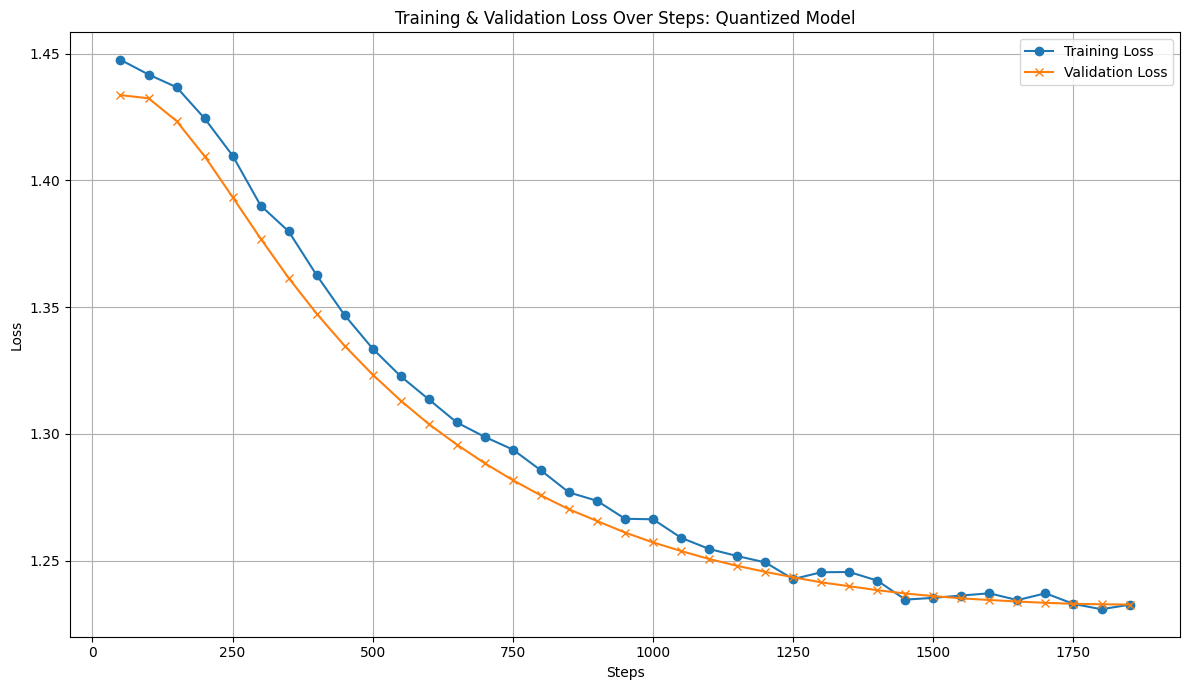

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data
steps = np.array([
    50, 100, 150, 200, 250, 300, 350, 400, 450, 500,
    550, 600, 650, 700, 750, 800, 850, 900, 950, 1000,
    1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500,
    1550, 1600, 1650, 1700, 1750, 1800, 1850
])

training_loss = np.array([
    1.447600, 1.441800, 1.436800, 1.424500, 1.409800, 1.390100, 1.379900, 1.362600,
    1.346800, 1.333600, 1.322700, 1.313600, 1.304500, 1.298800, 1.293800, 1.285600,
    1.276900, 1.273600, 1.266500, 1.266300, 1.259000, 1.254600, 1.251800, 1.249300,
    1.242700, 1.245400, 1.245500, 1.242100, 1.234600, 1.235300, 1.236200, 1.237100,
    1.234400, 1.237100, 1.232900, 1.230800, 1.232600
])

validation_loss = np.array([
    1.433662, 1.432423, 1.423455, 1.409581, 1.393424, 1.377060, 1.361493, 1.347436,
    1.334697, 1.323372, 1.313105, 1.303870, 1.295780, 1.288378, 1.281736, 1.275712,
    1.270249, 1.265640, 1.261074, 1.257178, 1.253783, 1.250627, 1.247933, 1.245569,
    1.243420, 1.241415, 1.239894, 1.238333, 1.237010, 1.235981, 1.235103, 1.234447,
    1.233837, 1.233345, 1.232946, 1.232760, 1.232650
])

# Plotting
plt.figure(figsize=(12, 7))
plt.plot(steps, training_loss, label='Training Loss', marker='o')
plt.plot(steps, validation_loss, label='Validation Loss', marker='x')
plt.title('Training & Validation Loss Over Steps: Quantized Model')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()